In [1]:
!pip install jiwer editdistance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 34.8 MB/s eta 0:00:00


In [2]:
# ctc_transcription_tokenizer_pipeline.py
# Full pipeline: CTC-based transcription tokenizer + LLM anchoring

# If running on Colab, uncomment:
# !pip install jiwer editdistance transformers torch torchaudio

from google.colab import drive
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from jiwer import wer, cer
import editdistance
import matplotlib.pyplot as plt
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM

In [3]:
# ----------------- Mount Drive -----------------
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
# ----------------- Vocabulary ------------------
vocab = list("abcdefghijklmnopqrstuvwxyz '") + ['|']
char_to_index = {c: i for i, c in enumerate(vocab)}
index_to_char = {i: c for c, i in char_to_index.items()}

# -------------- Dataset & Collation ------------
class TorgoDataset(Dataset):
    """Loads a pre-saved items_file of (wav_path, transcript) pairs."""
    def __init__(self, items_file, sample_rate=16000):
        assert os.path.exists(items_file), f"Items file not found: {items_file}"
        self.sample_rate = sample_rate
        self.items = torch.load(items_file)
        assert self.items, "Loaded items_file is empty"
        self.mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate, n_mels=80, n_fft=400, hop_length=160, center=False)

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        wav_fp, transcript = self.items[idx]
        try:
            waveform, sr = torchaudio.load(wav_fp)
        except:
            return None
        n_fft = self.mel_transform.n_fft
        if waveform.shape[-1] < n_fft:
            waveform = F.pad(waveform, (0, n_fft - waveform.shape[-1]))
        if sr != self.sample_rate:
            waveform = torchaudio.transforms.Resample(sr, self.sample_rate)(waveform)
        spec = self.mel_transform(waveform).squeeze(0).transpose(0, 1)
        target = torch.tensor([char_to_index[c] for c in transcript if c in char_to_index], dtype=torch.long)
        return spec, target

# collate_fn filters None and pads

def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if not batch:
        return None
    specs, targets = zip(*batch)
    spec_lens = torch.tensor([s.size(0) for s in specs], dtype=torch.long)
    tgt_lens  = torch.tensor([t.size(0) for t in targets], dtype=torch.long)
    specs_padded = pad_sequence(specs, batch_first=True).transpose(1, 2)
    targets_flat = torch.cat(targets)
    return specs_padded, targets_flat, spec_lens, tgt_lens

In [5]:
# ----------------- CTC Model -------------------
class CTCModel(nn.Module):
    """BiLSTM + linear projection for CTC-based transcription."""
    def __init__(self, input_dim=80, hidden_dim=128, vocab_size=len(vocab)):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.fc  = nn.Linear(hidden_dim * 2, vocab_size)
    def forward(self, x):
        out, _ = self.lstm(x.transpose(1, 2))  # [B, T, F]
        return self.fc(out)                     # [B, T, V]

# --------------- Decoding & Metrics ------------
def greedy_decode(logits, lengths, blank_idx):
    preds = logits.argmax(-1)
    results = []
    for i, L in enumerate(lengths):
        seq, prev, tokens = preds[i,:L].tolist(), None, []
        for c in seq:
            if c != blank_idx and c != prev:
                tokens.append(c)
            prev = c
        results.append(tokens)
    return results

def compute_wer_cer(preds, targets, tgt_lens):
    total_wer = total_cer = total_ed = 0
    offset = 0
    for i, p in enumerate(preds):
        L = tgt_lens[i].item()
        ref = ''.join(index_to_char[c] for c in targets[offset:offset+L].tolist())
        hyp = ''.join(index_to_char[c] for c in p)
        total_wer += wer(ref, hyp)
        total_cer += cer(ref, hyp)
        total_ed  += editdistance.eval(ref, hyp)
        offset += L
    n = len(preds)
    return total_wer/n, total_cer/n, total_ed/n

def compute_char_accuracy(preds, targets, tgt_lens):
    correct = total = 0
    offset = 0
    for i, p in enumerate(preds):
        L = tgt_lens[i].item()
        ref = targets[offset:offset+L].tolist()
        offset += L
        for a, b in zip(p, ref):
            correct += (a == b)
        total += L
    return correct/total if total>0 else 0.0

In [6]:
# ----------------- Training Loop --------------
def train_ctc(
    model, train_loader, val_loader=None,
    epochs=1000, lr=1e-3, save_dir=None,
    log_interval=100, early_stopping_patience=10
):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CTCLoss(blank=char_to_index['|'], zero_infinity=True)
    history = {k: [] for k in [
        'train_loss','train_wer','train_cer','train_acc',
        'val_loss','val_wer','val_cer','val_acc'
    ]}
    best_val_loss, patience = float('inf'), 0
    for ep in range(1, epochs+1):
        print(f"\n=== Epoch {ep}/{epochs} ===")
        t0 = time.time(); model.train(); run_loss=0
        for i, batch in enumerate(train_loader,1):
            if batch is None: continue
            specs, tgts, slens, tlens = batch
            specs, tgts = specs.to(device), tgts.to(device)
            optimizer.zero_grad()
            logp = model(specs).log_softmax(-1).permute(1,0,2)
            loss = criterion(logp, tgts, slens, tlens)
            loss.backward(); optimizer.step(); run_loss += loss.item()
            if i==1 or i%log_interval==0 or i==len(train_loader):
                print(f" Batch {i}/{len(train_loader)} Loss={loss.item():.4f} Elapsed={time.time()-t0:.1f}s")
        # compute train metrics
        avg_tr = run_loss/len(train_loader)
        model.eval(); all_p, all_tg, all_tl = [], [], []
        with torch.no_grad():
            for batch in train_loader:
                if batch is None: continue
                specs, tgts, slens, tlens = batch
                logits = model(specs.to(device))
                preds = greedy_decode(logits.cpu(), slens, char_to_index['|'])
                all_p.extend(preds); all_tg.append(tgts); all_tl.append(tlens)
        all_tg, all_tl = torch.cat(all_tg), torch.cat(all_tl)
        w, c, _ = compute_wer_cer(all_p, all_tg, all_tl)
        a = compute_char_accuracy(all_p, all_tg, all_tl)
        history['train_loss'].append(avg_tr)
        history['train_wer'].append(w)
        history['train_cer'].append(c)
        history['train_acc'].append(a)
        print(f" Epoch {ep} Train: loss={avg_tr:.4f}, WER={w:.4f}, CER={c:.4f}, ACC={a:.4f}, time={time.time()-t0:.1f}s")
        # validation
        if val_loader:
            vl, vp, vt, vtl = 0, [], [], []
            with torch.no_grad():
                for batch in val_loader:
                    if batch is None: continue
                    specs,tgts,slens,tlens = batch
                    specs,tgts = specs.to(device),tgts.to(device)
                    logp = model(specs).log_softmax(-1).permute(1,0,2)
                    vl += criterion(logp, tgts, slens, tlens).item()
                    logits = model(specs)
                    preds = greedy_decode(logits.cpu(), slens, char_to_index['|'])
                    vp.extend(preds); vt.append(tgts.cpu()); vtl.append(tlens)
            avg_vl = vl/len(val_loader)
            vt, vtl = torch.cat(vt), torch.cat(vtl)
            wv, cv, _ = compute_wer_cer(vp, vt, vtl)
            av = compute_char_accuracy(vp, vt, vtl)
            history['val_loss'].append(avg_vl)
            history['val_wer'].append(wv)
            history['val_cer'].append(cv)
            history['val_acc'].append(av)
            print(f" Epoch {ep} Val: loss={avg_vl:.4f}, WER={wv:.4f}, CER={cv:.4f}, ACC={av:.4f}")
            if avg_vl < best_val_loss: best_val_loss, patience = avg_vl, 0
            else: patience += 1; print(f" No improvement for {patience} epochs")
            if patience >= early_stopping_patience:
                print(f"Early stopping (patience={early_stopping_patience})")
                break
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            torch.save(model.state_dict(), os.path.join(save_dir, f"ctc_ep{ep}.pt"))
    return history

In [7]:
# ---------------- Cell 1: Data & Dataloaders ----------------
# Load pre-saved TORGO items and split into train/val/test
items_file = '/content/drive/MyDrive/Colab Notebooks/torgo_items.pt'
ds = TorgoDataset(items_file)
print(f"Loaded {len(ds)} items")
n = len(ds)
train_n, val_n = int(0.7*n), int(0.1*n)
test_n = n - train_n - val_n
train_ds, val_ds, test_ds = random_split(ds, [train_n, val_n, test_n])

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, collate_fn=collate_fn)

def print_loader_stats(loader, name):
    """Utility to print number of batches and first batch shape."""
    batches = len(loader)
    sample = next(iter(loader))
    print(f"{name}: {batches} batches, first batch specs shape = {sample[0].shape}")

print_loader_stats(train_loader, 'Train Loader')
print_loader_stats(val_loader, 'Val Loader')

Loaded 8214 items
Train Loader: 719 batches, first batch specs shape = torch.Size([8, 80, 420])
Val Loader: 103 batches, first batch specs shape = torch.Size([8, 80, 699])


In [8]:
# ---------------- Cell 2: Model Training ----------------
# Initialize model and run training with early stopping
model = CTCModel()
history = train_ctc(
    model,
    train_loader,
    val_loader,
    epochs=1000,
    lr=1e-3,
    save_dir='/content/drive/MyDrive/Colab Notebooks/ctc_checkpoints',
    log_interval=100,
    early_stopping_patience=10
)
print("Training complete. Epochs run:", len(history['train_loss']))


=== Epoch 1/1000 ===
 Batch 1/719 Loss=132.3649 Elapsed=7.8s
 Batch 100/719 Loss=3.3238 Elapsed=229.2s
 Batch 200/719 Loss=3.2997 Elapsed=430.9s
 Batch 300/719 Loss=3.2028 Elapsed=634.3s
 Batch 400/719 Loss=3.3601 Elapsed=829.9s
 Batch 500/719 Loss=3.2024 Elapsed=1023.3s
 Batch 600/719 Loss=3.3809 Elapsed=1217.2s
 Batch 700/719 Loss=3.4059 Elapsed=1425.6s
 Batch 719/719 Loss=3.2794 Elapsed=1461.6s
 Epoch 1 Train: loss=5.9720, WER=1.0000, CER=1.0000, ACC=0.0000, time=1531.0s
 Epoch 1 Val: loss=3.3096, WER=1.0000, CER=1.0000, ACC=0.0000

=== Epoch 2/1000 ===
 Batch 1/719 Loss=3.1840 Elapsed=0.1s
 Batch 100/719 Loss=3.3390 Elapsed=10.2s
 Batch 200/719 Loss=3.1261 Elapsed=20.4s
 Batch 300/719 Loss=3.3366 Elapsed=30.9s
 Batch 400/719 Loss=3.0063 Elapsed=41.0s
 Batch 500/719 Loss=3.2929 Elapsed=51.0s
 Batch 600/719 Loss=3.1558 Elapsed=61.3s
 Batch 700/719 Loss=3.4230 Elapsed=71.7s
 Batch 719/719 Loss=4.7024 Elapsed=73.6s
 Epoch 2 Train: loss=3.3651, WER=1.0000, CER=1.0000, ACC=0.0000, time=

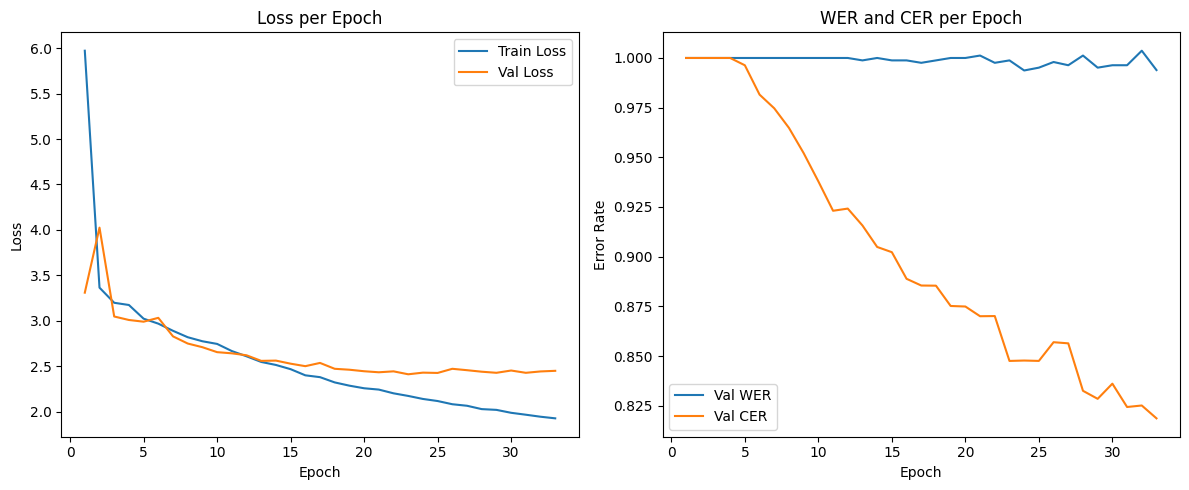

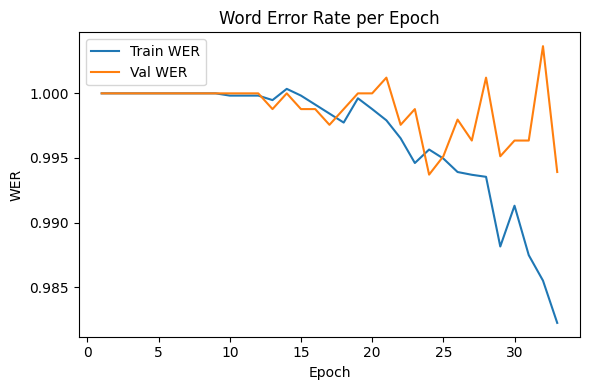

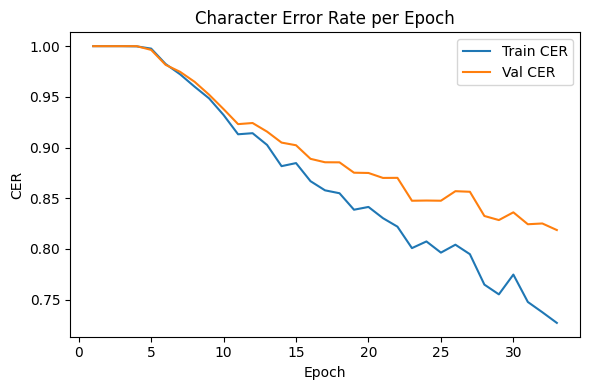

In [14]:
# ---------------- Cell 3: Plotting Metrics ----------------
epochs = list(range(1, len(history['train_loss']) + 1))
plt.figure(figsize=(12,5))
# Loss
plt.subplot(1,2,1)
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'],   label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# Error Rates
plt.subplot(1,2,2)
plt.plot(epochs, history['val_wer'], label='Val WER')
plt.plot(epochs, history['val_cer'], label='Val CER')
plt.title('WER and CER per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Error Rate')
plt.legend()
plt.tight_layout()
plt.show()

# ------ Additional: Separate WER and CER Plots ------
# WER Curve (Train & Val)
plt.figure(figsize=(6,4))
plt.plot(epochs, history['train_wer'], label='Train WER')
plt.plot(epochs, history['val_wer'],   label='Val WER')
plt.title('Word Error Rate per Epoch')
plt.xlabel('Epoch')
plt.ylabel('WER')
plt.legend()
plt.tight_layout()
plt.show()

# CER Curve (Train & Val)
plt.figure(figsize=(6,4))
plt.plot(epochs, history['train_cer'], label='Train CER')
plt.plot(epochs, history['val_cer'],   label='Val CER')
plt.title('Character Error Rate per Epoch')
plt.xlabel('Epoch')
plt.ylabel('CER')
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
import glob
# ---------------- Cell 4: Inference with LLM ----------------
# Automatically detect the latest saved checkpoint
ckpt_dir = '/content/drive/MyDrive/Colab Notebooks/ctc_checkpoints'
all_ckpts = sorted(glob.glob(os.path.join(ckpt_dir, 'ctc_ep*.pt')))
if not all_ckpts:
    raise FileNotFoundError(f"No checkpoints found in {ckpt_dir}")
best_ckpt = all_ckpts[-1]
print(f"Loading checkpoint: {best_ckpt}")
model.load_state_dict(torch.load(best_ckpt))
model.to('cuda' if torch.cuda.is_available() else 'cpu').eval()

# Load LLM & tokenizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
llm_name  = "facebook/opt-350m"
tokenizer = AutoTokenizer.from_pretrained(llm_name)
llm       = AutoModelForCausalLM.from_pretrained(llm_name).to(device)

# Run one sample inference
test_loader = DataLoader(test_ds, batch_size=1, shuffle=True, collate_fn=collate_fn)
specs, tgts, slens, _ = next(iter(test_loader))
with torch.no_grad():
    logits = model(specs.to(device))
pred = greedy_decode(logits.cpu(), slens, char_to_index['|'])[0]
prompt = ''.join(index_to_char[i] for i in pred)
print("CTC prompt:", prompt)
inputs = tokenizer(prompt, return_tensors="pt").to(device)
out = llm.generate(**inputs, max_new_tokens=100)
print("LLM output:", tokenizer.decode(out[0], skip_special_tokens=True))

Loading checkpoint: /content/drive/MyDrive/Colab Notebooks/ctc_checkpoints/ctc_ep9.pt


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/644 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/663M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/662M [00:00<?, ?B/s]

CTC prompt: 
LLM output: 
The following is a list of the most popular and most popular websites in the world.

The following is a list of the most popular and most popular websites in the world.

The following is a list of the most popular and most popular websites in the world.

The following is a list of the most popular and most popular websites in the world.

The following is a list of the most popular and most popular websites in the world.

The following is a


In [17]:
# ---------------- Cell 5: Inference with LLM ----------------
# Automatically detect the latest saved checkpoint
ckpt_dir = '/content/drive/MyDrive/Colab Notebooks/ctc_checkpoints'
all_ckpts = sorted(glob.glob(os.path.join(ckpt_dir, 'ctc_ep*.pt')))
if not all_ckpts:
    raise FileNotFoundError(f"No checkpoints found in {ckpt_dir}")
best_ckpt = all_ckpts[-1]
print(f"Loading checkpoint: {best_ckpt}")
model.load_state_dict(torch.load(best_ckpt))
model.to(device).eval()

# Load LLM & tokenizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
llm_name  = "facebook/opt-350m"
tokenizer = AutoTokenizer.from_pretrained(llm_name)
llm       = AutoModelForCausalLM.from_pretrained(llm_name).to(device)

# Run inference on multiple test examples and generate several outputs per prompt
print("--- Sample Inference Outputs ---")

test_loader = DataLoader(test_ds, batch_size=1, shuffle=True, collate_fn=collate_fn)
max_examples = 5         # number of test examples to show
num_return_seq = 3       # outputs per example
count = 0

for specs, tgts, slens, _ in test_loader:
    if specs is None:
        continue
    with torch.no_grad():
        logits = model(specs.to(device))
    pred = greedy_decode(logits.cpu(), slens, char_to_index['|'])[0]
    ctc_prompt = ''.join(index_to_char[i] for i in pred)
    if not ctc_prompt.strip():
        # skip empty prompts
        continue
    print(f"Example {count+1} CTC prompt: {ctc_prompt}")
    inputs = tokenizer(ctc_prompt, return_tensors="pt", padding=True).to(device)
    outputs = llm.generate(
        **inputs,
        do_sample=True,
        top_p=0.9,
        num_return_sequences=num_return_seq,
        max_new_tokens=100
    )
    for idx, out in enumerate(outputs, 1):
        text = tokenizer.decode(out, skip_special_tokens=True)
        print(f"  LLM output #{idx}: {text}")
    count += 1
    if count >= max_examples:
        break

Loading checkpoint: /content/drive/MyDrive/Colab Notebooks/ctc_checkpoints/ctc_ep9.pt
--- Sample Inference Outputs ---
Example 1 CTC prompt: k
  LLM output #1: kurwa  za raz znam s nema ni kakavu, ako neki nema ni takmi, ako sam bio da će ozbiljni prihod, ne bi bilo dobio svojim životom ozbiljni jedan prva odgovor.
Vozde kod kuće nema nešto znati. Ne bih bilo prona
  LLM output #2: karma whore
You have some really stupid comments.   Not everyone wants a gold star for their "favorites" though.
You need to stop reading
I mean I'm not gonna downvote you just because your comment didn't make me downvote myself.   Also, I agree.   The idea of a gold star for someone with a shitty opinion is stupid and should be called out.
  LLM output #3: korean player here, and its really weird to me how you can play in a group of people but not be a "bad person" by having a good mindset.
I feel like there's more "bad" in Korean players than there is in American players. I'm a big fan of the Korean scene,